#### Load Dataset

In [1]:
# Import required modules
import numpy as np
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
from IPython.display import display
import seaborn as sns; sns.set(font_scale=1.2)

import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Load the data into variable 'df' from pickled object
from funcs import load_df
df = load_df()

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null bool
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null category
AppointmentDOW    110527 non-null category
age_range         110527 non-null category
dtypes: bool(1), category(5), datetime64[ns](2), int64(10), object(1)
memory usage: 11.2+ MB


#### Remove ID variables

In [2]:
#Remove attributes not usefull
del df['PatientId']
del df['AppointmentID']

df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 17 columns):
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null bool
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null category
AppointmentDOW    110527 non-null category
age_range         110527 non-null category
dtypes: bool(1), category(5), datetime64[ns](2), int64(8), object(1)
memory usage: 9.5+ MB


#### List Continuous Variables

In [3]:
df.describe()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,DaysInAdvance
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.089218,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183792
std,23.109921,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254924
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


In [4]:
df.head()

,Gender,ScheduledDay,ScheduledTime,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,DaysInAdvance,ScheduledDOW,AppointmentDOW,age_range
0,F,2016-04-29,18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,False,0,Friday,Friday,adult
1,M,2016-04-29,16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,False,0,Friday,Friday,adult
2,F,2016-04-29,16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,False,0,Friday,Friday,adult
3,F,2016-04-29,17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,False,0,Friday,Friday,child
4,F,2016-04-29,16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,False,0,Friday,Friday,adult


#### Simple scatter plot of Continuous Features vs NoShow

C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


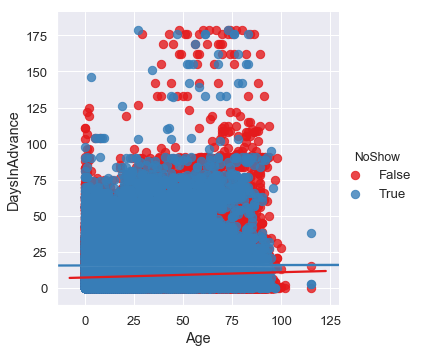

In [5]:
#plot
sns.lmplot('Age','DaysInAdvance', data=df, hue='NoShow', palette='Set1', fit_reg=True, scatter_kws={"s": 70})

In [6]:
# NOTE: calling describe when not all the data is categorical will cause the 
# categorical variables to be removed
df[['ScheduledDay','ScheduledTime','AppointmentDay',
    'Gender','age_range','Neighbourhood','Scholarship',
    'Hypertension','Diabetes','Alcoholism','Handicap',
    'SMSReceived','ScheduledDOW','AppointmentDOW','NoShow']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Scholarship,110527.0,0.098266,0.297675,0.0,0.0,0.0,0.0,1.0
Hypertension,110527.0,0.197246,0.397921,0.0,0.0,0.0,0.0,1.0
Diabetes,110527.0,0.071865,0.258265,0.0,0.0,0.0,0.0,1.0
Alcoholism,110527.0,0.030400,0.171686,0.0,0.0,0.0,0.0,1.0
Handicap,110527.0,0.022248,0.161543,0.0,0.0,0.0,0.0,4.0
SMSReceived,110527.0,0.321026,0.466873,0.0,0.0,0.0,1.0,1.0


#### One Hot Encode Variables

In [7]:
# perform one-hot encoding of the categorical data 
tmp_df = pd.get_dummies(df.Handicap,prefix='Handicap')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.AppointmentDOW,prefix='AppointmentDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.ScheduledDOW,prefix='ScheduledDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

#tmp_df = pd.get_dummies(df.Neighbourhood,prefix='Neighbourhood')
#df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.age_range,prefix='age_range')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

In [8]:
# replace the current Gender atribute with something slightly more intuitive and readable
df['IsMale'] = df.Gender=='male' 
df.IsMale = df.IsMale.astype(np.int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 40 columns):
Gender                      110527 non-null category
ScheduledDay                110527 non-null datetime64[ns]
ScheduledTime               110527 non-null object
AppointmentDay              110527 non-null datetime64[ns]
Age                         110527 non-null int64
Neighbourhood               110527 non-null category
Scholarship                 110527 non-null int64
Hypertension                110527 non-null int64
Diabetes                    110527 non-null int64
Alcoholism                  110527 non-null int64
Handicap                    110527 non-null int64
SMSReceived                 110527 non-null int64
NoShow                      110527 non-null bool
DaysInAdvance               110527 non-null int64
ScheduledDOW                110527 non-null category
AppointmentDOW              110527 non-null category
age_range                   110527 non-null category
Handic

#### Remove variables

In [9]:
# Now let's clean up the dataset
if 'Gender' in df:
    del df['Gender'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Handicap' in df:    
    del df['Handicap'] # get reid of the original category as it is now one-hot encoded
    
if 'ScheduledDOW' in df:    
    del df['ScheduledDOW'] # get reid of the original category as it is now one-hot encoded
    
if 'AppointmentDOW' in df:    
    del df['AppointmentDOW'] # get reid of the original category as it is now one-hot encoded

if 'Neighbourhood' in df:    
    del df['Neighbourhood'] # get reid of the original category as it is now one-hot encoded

#remove categorical variables for logistic regression analysis
if 'age_range' in df:
    del df['age_range']

if 'AppointmentID' in df:
    del df['AppointmentID']
    
if 'ScheduledDay' in df:
    del df['ScheduledDay']
    
if 'ScheduledTime' in df:
    del df['ScheduledTime']

if 'AppointmentDay' in df:
    del df['AppointmentDay']
    
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 31 columns):
Age                         110527 non-null int64
Scholarship                 110527 non-null int64
Hypertension                110527 non-null int64
Diabetes                    110527 non-null int64
Alcoholism                  110527 non-null int64
SMSReceived                 110527 non-null int64
NoShow                      110527 non-null bool
DaysInAdvance               110527 non-null int64
Handicap_0                  110527 non-null uint8
Handicap_1                  110527 non-null uint8
Handicap_2                  110527 non-null uint8
Handicap_3                  110527 non-null uint8
Handicap_4                  110527 non-null uint8
AppointmentDOW_Monday       110527 non-null uint8
AppointmentDOW_Tuesday      110527 non-null uint8
AppointmentDOW_Wednesday    110527 non-null uint8
AppointmentDOW_Thursday     110527 non-null uint8
AppointmentDOW_Friday       110527 non-n

In [10]:
df.head()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,NoShow,DaysInAdvance,Handicap_0,Handicap_1,...,ScheduledDOW_Tuesday,ScheduledDOW_Wednesday,ScheduledDOW_Thursday,ScheduledDOW_Friday,ScheduledDOW_Saturday,ScheduledDOW_Sunday,age_range_child,age_range_adult,age_range_senior,IsMale
0,62,0,1,0,0,0,False,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,56,0,0,0,0,0,False,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,62,0,0,0,0,0,False,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,8,0,0,0,0,0,False,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,56,0,1,1,0,0,False,0,1,0,...,0,0,0,1,0,0,0,1,0,0


## Create Models (50pts))

#### Logistic Regression 
#### Assumptions:
<br>-Binary logistic regression requires the dependent variable to be binary.
<br>-For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
<br>-Only the meaningful variables should be included.
<br>-The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
<br>-The independent variables are linearly related to the log odds.
<br>-Logistic regression requires quite large sample sizes.

ref: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [11]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [12]:
df['NoShow'].value_counts()

False    88208
True     22319
Name: NoShow, dtype: int64

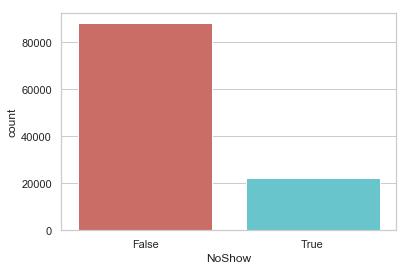

<Figure size 432x288 with 0 Axes>

In [13]:
sns.countplot(x='NoShow', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [14]:
count_NoShow = len(df[df['NoShow']==0])
count_Show = len(df[df['NoShow']==1])
pct_of_NoShow = count_NoShow/(count_NoShow+count_Show)
print("percentage of no shows are", pct_of_NoShow*100)
pct_of_Show = count_Show/(count_NoShow+count_Show)
print("percentage of shows", pct_of_Show*100)

percentage of no shows are 79.8067440534892
percentage of shows 20.193255946510806


Our classes are imbalanced, and the ratio of NoShows to Shows instances is 79:20.

In [15]:
df.groupby('NoShow').mean()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,DaysInAdvance,Handicap_0,Handicap_1,Handicap_2,...,ScheduledDOW_Tuesday,ScheduledDOW_Wednesday,ScheduledDOW_Thursday,ScheduledDOW_Friday,ScheduledDOW_Saturday,ScheduledDOW_Sunday,age_range_child,age_range_adult,age_range_senior,IsMale
NoShow,,,,,,,,,,,,,,,,,,,,,
False,37.790495,0.093903,0.204392,0.073837,0.030417,0.291334,8.754659,0.979208,0.019001,0.001655,...,0.236679,0.219742,0.162944,0.170370,0.000261,0.0,0.229786,0.642844,0.127369,0
True,34.317667,0.115507,0.169004,0.064071,0.030333,0.438371,15.831937,0.981764,0.016399,0.001658,...,0.237107,0.218513,0.165778,0.174157,0.000045,0.0,0.250952,0.656481,0.092567,0


#### Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

#### Creating Numpy Matrices

In [16]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'NoShow' in df:
    y = df['NoShow'].values # get the labels we want
    del df['NoShow'] # get rid of the class label
    X = df.values # use everything else to predict!

In [17]:
## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
#    have converted them into simple matrices to use with scikit learn
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, train_size=0.8)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=0.8)


In [18]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt


# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
        #NOTE: as you increase C, test diff values by grid search
    #another par is balanced=TRUE/FALSE instead of class weight
    
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration

# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.8010494888265629
confusion matrix
 [[17637   126]
 [ 4272    71]]


C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.7936306885008595
confusion matrix
 [[17478   151]
 [ 4411    66]]


C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.797701981362526
confusion matrix
 [[17557   156]
 [ 4316    77]]


In [19]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.80028047 0.79688772 0.80448747]


In [20]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dgeislinger\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.79435447 0.79525921 0.79688772]


<function __main__.lr_explor(cost)>

#### Support Vector Machines 

Add Chris's SVM here

## Model Advantages (10pts)
Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

## Interpret Feature Importance (30pts)
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

In [21]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

Age has weight of -0.012976554797192561
Scholarship has weight of 0.23807953915787924
Hypertension has weight of -0.0028346261060515515
Diabetes has weight of 0.14765471397623933
Alcoholism has weight of 0.22139768846971394
SMSReceived has weight of 0.3749376094181948
DaysInAdvance has weight of 0.02337693616803588
Handicap_0 has weight of -0.2936659903603306
Handicap_1 has weight of -0.2262309840368932
Handicap_2 has weight of -0.24340483360452791
Handicap_3 has weight of 0.07183220979941093
Handicap_4 has weight of 0.02725282858540022
AppointmentDOW_Monday has weight of -0.162062721669163
AppointmentDOW_Tuesday has weight of -0.20493300186657626
AppointmentDOW_Wednesday has weight of -0.20942315516495752
AppointmentDOW_Thursday has weight of -0.2125365714053373
AppointmentDOW_Friday has weight of -0.040874173625117124
AppointmentDOW_Saturday has weight of 0.16561285411956359
AppointmentDOW_Sunday has weight of 0.0
ScheduledDOW_Monday has weight of -0.025529609701973658
ScheduledDOW_T

In [22]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

NameError: name 'X_train' is not defined

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

In [ ]:
import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

**For more improvement and guarding against overfitting:** At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?

In [ ]:
Xnew = df[['Age','ScheduledDOW_Saturday','AppointmentDOW_Wednesday']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['Age','ScheduledDOW_Saturday','AppointmentDOW_Wednesday'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

### Cross Validation
Cross validation is performed using repeated holdout via ShuffleSplit()

Ten folds are used
The split is: 80% training data and 20% test data
A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [ ]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=4, test_size=0.20, random_state=0)

### Classifier Evaluation
The following functions performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, recall, f1 score, and a confusion matrix for each model.

In [ ]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv_object, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

In [ ]:
#Logisitic regression 5-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds = 5
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

In [ ]:
#Diplay the top model parameters
regGridSearch.best_estimator_

In [ ]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X, y, cv_object)

In [ ]:
EvaluateClassifierEstimator2(classifierEst, X, y, 10)

In [ ]:
#sort

# DANGER SVM ZONE! MOST OF THIS IS STILL BROKE AF


Alot of this is broke since i haven't been able to get the main file to run, and some of it is experimental still. Will be dramatically updating and adding analysis. Only section of merit is the try other svm method at bottom.

In [ ]:
pd.set_option('display.max_columns', 500)


In [ ]:
df2.head()

In [ ]:
len(X)

In [ ]:
# perform one-hot encoding of the categorical data 
tmp_df2 = pd.get_dummies(df2.Handicap,prefix='Handicap')
df2 = pd.concat((df2,tmp_df2),axis=1) # add back into the dataframe

tmp_df2 = pd.get_dummies(df2.AppointmentDOW,prefix='AppointmentDOW')
df2 = pd.concat((df2,tmp_df2),axis=1) # add back into the dataframe

tmp_df2 = pd.get_dummies(df2.ScheduledDOW,prefix='ScheduledDOW')
df2 = pd.concat((df2,tmp_df2),axis=1) # add back into the dataframe

# replace the current Sex atribute with something slightly more intuitive and readable
df2['IsMale'] = df2.Gender=='male' 
df2.IsMale = df2.IsMale.astype(np.int)

df2.info()

# Now let's clean up the dataset
if 'Gender' in df2:
    del df2['Gender'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Handicap' in df2:    
    del df2['Handicap'] # get reid of the original category as it is now one-hot encoded
    
if 'ScheduledDOW' in df2:    
    del df2['ScheduledDOW'] # get reid of the original category as it is now one-hot encoded
    
if 'AppointmentDOW' in df2:    
    del df2['AppointmentDOW'] # get reid of the original category as it is now one-hot encoded

if 'Neighbourhood' in df2:    
    del df2['Neighbourhood'] # get reid of the original category as it is now one-hot encoded

#remove categorical variables for logistic regression analysis
if 'age_range' in df2:
    del df2['age_range']

if 'AppointmentID' in df2:
    del df2['AppointmentID']
    
if 'ScheduledDay' in df2:
    del df2['ScheduledDay']
    
if 'ScheduledTime' in df2:
    del df2['ScheduledTime']

if 'AppointmentDay' in df2:
    del df2['AppointmentDay']
    
df2.info() 

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'NoShow' in df2:
    y = df2['NoShow'].values # get the labels we want
    del df2['NoShow'] # get rid of the class label
    X = df2.values # use everything else to predict!

In [ ]:
import random
randtrain=random.sample(train_indices,2000)

In [ ]:

X_train2=X[randtrain]
y_train2=y[randtrain]
random.sample()
randtest=random.sample(train_indices,5000)
X_test2=X[randtest]
y_test2=y[randtest]

In [ ]:
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train2 = X[randtrain]
    y_train2 = y[randtrain]
    X_test2 = X[randtest]
    y_test2 = y[randtest]

In [ ]:
X_test2

In [ ]:
len(y_test2)

In [ ]:
from sklearn.preprocessing import StandardScaler
#use same train indicies
scl_obj = StandardScaler()

scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


In [ ]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC() # get object
svm_clf.fit(X_train2, y_train2)  # train object

In [ ]:
y_hat2 = svm_clf.predict(X_test2) # get test set precitions

acc = mt.accuracy_score(y_test2,y_hat2)
conf = mt.confusion_matrix(y_test2,y_hat2)
print('accuracy:', acc )
print(conf)

In [ ]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

## Try other way for SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
#use same train indicies
scl_obj = StandardScaler()

scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html 
notes on this that i'm working on...

loss parameters
‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’
penalty options
str, ‘none’, ‘l2’, ‘l1’, or ‘elasticnet’

l1 and hinge result in a 0 false prediction, which may have legitimate value from an operational standpoint....

In [ ]:
%%time
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l1')

scl = StandardScaler()
for train_indices, test_indices in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_indices]),y[train_indices])
    yhat = svm_sgd.predict(scl.transform(X[test_indices]))
    
    conf2 = mt.confusion_matrix(y[test_indices],yhat)
    acc2 = mt.accuracy_score(y[test_indices],yhat)

print('SVM Accuracy:', acc2)
print(conf2)


In [ ]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

## Interpret Support Vectors (10pts)